Students:

- ...
- ...
- ...

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader
%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
#if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    #!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 9


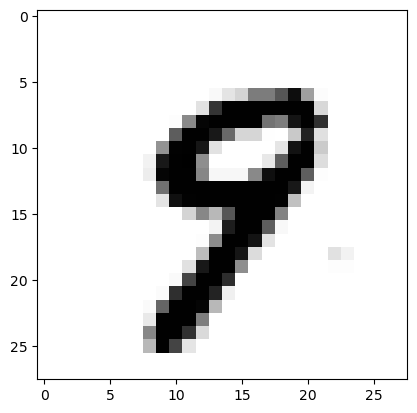

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        # run the backward 
        self.d( self.backptr, self.gradient )
        for o in self.backptr:
            if isinstance(o, Tensor) and not isinstance(o, Parameter) and o.require_grad:
                o.backward()
    
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x): 
    v=np.tanh(x.data)
    output=Tensor(v,require_grad=x.require_grad)
    output.d=backward_tanh
    output.backptr=[x]
    return output

def backward_tanh(backptr, g):
    x, = backptr
    if x.require_grad:
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    """
    Input:
    - W: a Parameter of shape (D, M)
    - b: a Parameter of shape (M,)
    - x: a Tensor of shape (D,)
    Output:
    - a Tensor of shape (M,)
    """
    v = W.data @ x.data + b.data
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output


def backward_affine_transform(backptr, g):

    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1, 1) @ x.data.reshape(1, -1))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(W.data.T @ g)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    x = x - np.max(x)
    x = np.exp(x)
    x = x / np.sum(x)
    return x

def nll(x, gold):
    
    v = -np.log(_softmax(x.data)[gold])
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]
    
    return output

def backward_nll(backptr, g):
    x, gold = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        ft=_softmax(x.data)
        ft[gold] -= 1
        x.accumulate_gradient(g * ft)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), np.sqrt(6. / (W.shape[0] + W.shape[1])), W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / W.shape[1]), np.sqrt(6. / W.shape[1]), W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):

    # Number of training samples
    n_training = train_data[0].shape[0]
    n_dev = dev_data[0].shape[0]

    # Array containing some stats
    avg_losses = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    dev_acc_epoch = np.zeros(n_epochs)
    dev_acc  =[]
     
    # parameters to store score and parameters of the best model on dev
    best_dev_accuracy = 0
    best_params = None  
    

    # For each epoch...
    for epoch_i in range(n_epochs ):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs ))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        train_loss = 0
        train_correct = 0

        # shuffle the data before each epoch
        indices = np.random.permutation(n_training)
        train_data_shuffled = (train_data[0][indices], train_data[1][indices])   

        for i, (x, y) in enumerate (zip (train_data_shuffled[0], train_data_shuffled[1])):
            # forward pass
            y_hat = network.forward(Tensor(x))
            loss = nll(y_hat, y)
            train_loss += loss.data

            # backward pass
            optimizer.zero_grad()
            loss.backward(1.0)
            optimizer.step()

            # compute accuracy on train set
            train_correct += int(np.argmax(y_hat.data) == y)

            # Compute avg loss, avg train accuracy and dev accuracy
            avg_losses[epoch_i] = train_loss/ n_training
            train_acc[epoch_i]  = train_correct/ n_training

        
            # evaluate the model on the dev data after 10000 training examples (5 evaluation per epoch on dev)
            if (i+1)% 10000 == 0:
                local_acc=[]
                dev_correct = 0
                for x, y in zip(dev_data[0], dev_data[1]):
                    y_hat = network.forward(Tensor(x))
                    dev_correct += int(np.argmax(y_hat.data) == y)

                dev_accuracy = dev_correct / n_dev  
                print(f" current Dev accuracy: {dev_accuracy:.3f}")
                local_acc.append(dev_accuracy)
                dev_acc.append(dev_accuracy)

                # check if dev accuracy has improved and update best parameters
                if dev_accuracy > best_dev_accuracy:
                    best_dev_accuracy = dev_accuracy
                    best_params = (network.W, network.b)

            

        dev_acc_epoch[epoch_i] = max(local_acc)
        print('best dev accuracy: ', best_dev_accuracy)
            # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
            
    

        print(f"Average loss: {avg_losses[epoch_i]:.3f}")
        print(f"Train accuracy: {train_acc[epoch_i]}")
        print(f"Dev accuracy: {max(dev_acc):.3f}")
        print("dev accuracy epoch: {:}".format(dev_acc_epoch[epoch_i]))
        print("training epcoh took: {:}".format(training_time))
        #print(f"Dev loss:   {dev_loss_e}") 
    print(len(dev_acc))
    return {"losses": avg_losses, "train_acc": train_acc, "dev_acc": dev_acc_epoch}, best_params
    

In [17]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.896
 current Dev accuracy: 0.912
 current Dev accuracy: 0.916
 current Dev accuracy: 0.916
 current Dev accuracy: 0.919
best dev accuracy:  0.9195
Average loss: 0.378
Train accuracy: 0.8904
Dev accuracy: 0.919
dev accuracy epoch: 0.9195
training epcoh took: 0:00:12

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.922
 current Dev accuracy: 0.920
 current Dev accuracy: 0.917
 current Dev accuracy: 0.918
 current Dev accuracy: 0.920
best dev accuracy:  0.922
Average loss: 0.310
Train accuracy: 0.91188
Dev accuracy: 0.922
dev accuracy epoch: 0.9199
training epcoh took: 0:00:11

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.920
 current Dev accuracy: 0.921
 current Dev accuracy: 0.919
 current Dev accuracy: 0.921
 current Dev accuracy: 0.924
best dev accuracy:  0.9238
Average loss: 0.297
Train accuracy: 0.9164
Dev accuracy: 0.924
dev accuracy epoch: 0.9238
training epcoh took: 0:00:1

({'losses': array([0.37751529, 0.31031748, 0.29721944, 0.29028121, 0.28597462]),
  'train_acc': array([0.8904 , 0.91188, 0.9164 , 0.91798, 0.91894]),
  'dev_acc': array([0.9195, 0.9199, 0.9238, 0.9227, 0.9243])},
 (<__main__.Parameter at 0x23495862f40>,
  <__main__.Parameter at 0x23495862a90>))

In [18]:
def plot_loss_acc(avg_losses, train_acc, dev_acc_epoch):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(avg_losses, label='train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='train accuracy')
    ax[1].plot(dev_acc_epoch, label='dev accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)



======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.923
 current Dev accuracy: 0.923
 current Dev accuracy: 0.925
 current Dev accuracy: 0.926
 current Dev accuracy: 0.924
best dev accuracy:  0.926
Average loss: 0.282
Train accuracy: 0.9203
Dev accuracy: 0.926
dev accuracy epoch: 0.9239
training epcoh took: 0:00:12

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.921
 current Dev accuracy: 0.925
 current Dev accuracy: 0.922
 current Dev accuracy: 0.923
 current Dev accuracy: 0.924
best dev accuracy:  0.926
Average loss: 0.279
Train accuracy: 0.92092
Dev accuracy: 0.926
dev accuracy epoch: 0.9241
training epcoh took: 0:00:12

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.925
 current Dev accuracy: 0.921
 current Dev accuracy: 0.924
 current Dev accuracy: 0.922
 current Dev accuracy: 0.927
best dev accuracy:  0.9271
Average loss: 0.277
Train accuracy: 0.9218
Dev accuracy: 0.927
dev accuracy epoch: 0.9271
training epcoh took: 0:00:12

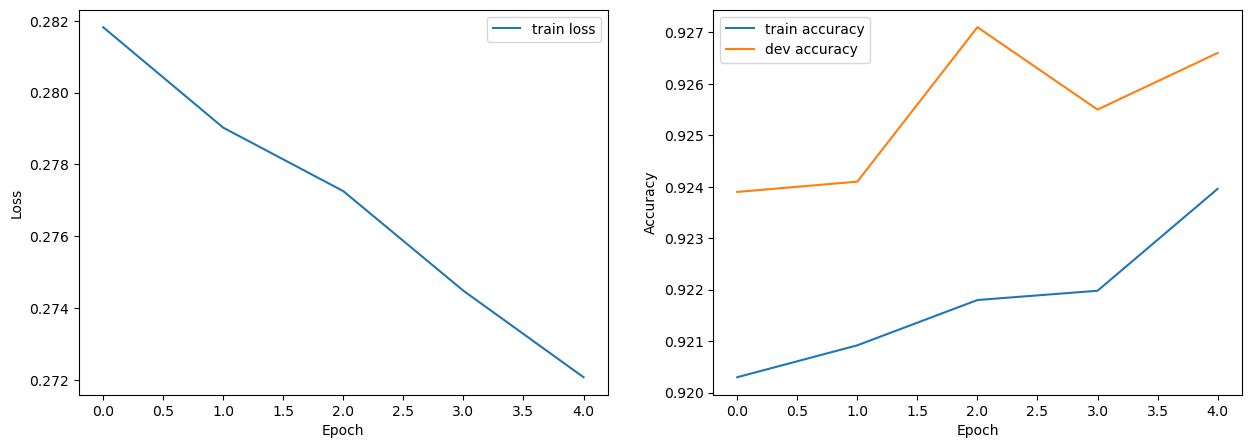

In [19]:
plot_loss_acc(history["losses"], history["train_acc"], history["dev_acc"])

In [20]:
n_test = test_data[0].shape[0]
W_best, b_best = best_params
test_correct = 0
for x, y in zip(test_data[0], test_data[1]):
    y_hat = affine_transform(W_best, b_best, x)
    test_correct += int(np.argmax(y_hat.data) == y)

test_accuracy = test_correct / n_test

print("Best parameters: test_accuracy=%.4f" % test_accuracy)

Best parameters: test_accuracy=0.9206


After you finished the linear network, you can move to a deep network!

In [23]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        self.tanh = tanh
        self.n_layers=n_layers
        
        dim_in = dim_input
        dim_out = hidden_dim
        for i in range(self.n_layers):
            self.W.append(Parameter(np.ndarray((dim_out, dim_in))))
            self.b.append(Parameter(np.ndarray(dim_out)))
            dim_in, dim_out = hidden_dim, hidden_dim
        
        self.output_proj = Parameter(np.ndarray((dim_output, dim_in)))
        self.output_bias = Parameter(np.ndarray(dim_output))
                
        self.init_parameters()
                          
        
    def init_parameters(self):
            for w in self.W:
                          kaiming_init(w.data) 
            for b in self.b:
                          zero_init(b.data)
                          
    def forward(self, x):
        for i in range(self.n_layers):
            #print(type(self.W[i].data))
            x = affine_transform(self.W[i] ,self.b[i], x)
            x = tanh(x) if self.tanh else relu(x)
        x = affine_transform(self.output_proj,self.output_bias, x) 
        
        
        return x

In [24]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

history, best_params= training_loop(network, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.910
 current Dev accuracy: 0.937
 current Dev accuracy: 0.953
 current Dev accuracy: 0.962
 current Dev accuracy: 0.955
best dev accuracy:  0.9619
Average loss: 0.297
Train accuracy: 0.91564
Dev accuracy: 0.962
dev accuracy epoch: 0.9554
training epcoh took: 0:01:00

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.958
 current Dev accuracy: 0.958
 current Dev accuracy: 0.963
 current Dev accuracy: 0.957
 current Dev accuracy: 0.967
best dev accuracy:  0.9668
Average loss: 0.130
Train accuracy: 0.96138
Dev accuracy: 0.967
dev accuracy epoch: 0.9668
training epcoh took: 0:01:52

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.967
 current Dev accuracy: 0.969
 current Dev accuracy: 0.969
 current Dev accuracy: 0.955
 current Dev accuracy: 0.968
best dev accuracy:  0.9689
Average loss: 0.096
Train accuracy: 0.97112
Dev accuracy: 0.969
dev accuracy epoch: 0.9675
training epcoh took: 0:0

({'losses': array([0.29686503, 0.13020744, 0.09586414, 0.07731774, 0.06214468]),
  'train_acc': array([0.91564, 0.96138, 0.97112, 0.97668, 0.98116]),
  'dev_acc': array([0.9554, 0.9668, 0.9675, 0.9718, 0.9742])},
 ([<__main__.Parameter at 0x23494f24130>,
   <__main__.Parameter at 0x234958941f0>]))

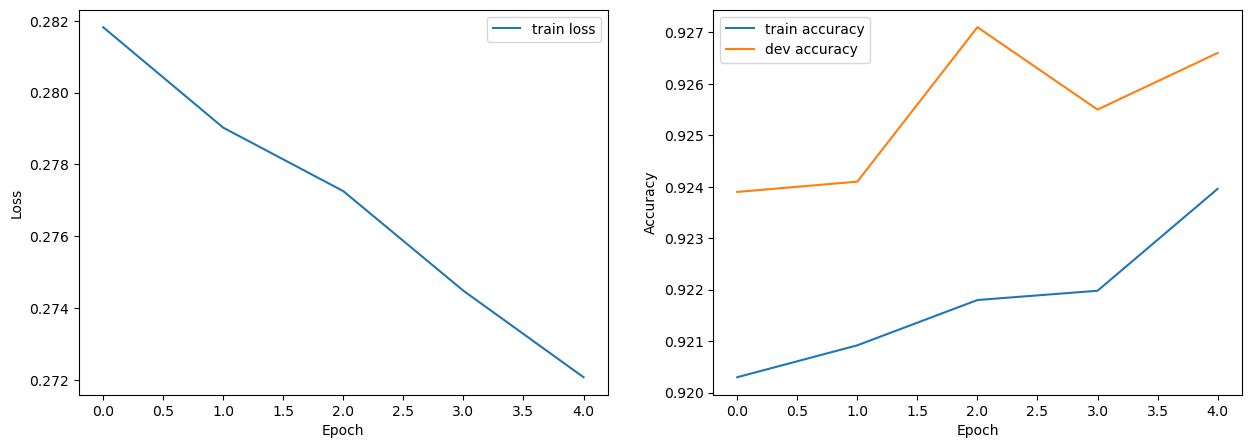

In [25]:
plot_loss_acc(history["losses"], history["train_acc"], history["dev_acc"])

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [73]:
class SGD_momentum:
    def __init__(self, params, lr=0.1, momentum=0.9):
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.velocities = []
        
        for p in self.params:
            self.velocities.append(np.zeros_like(p.data))        
        
    def step(self):
        for i, p in enumerate(self.params):
            v = self.velocities[i]
            #print("v", v)
            v[:] = self.momentum * v + (1 - self.momentum) * p.gradient
            p.data[:] = p.data - self.lr * v
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()


In [75]:
dim_input = 28*28
dim_output = 10

model = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD_momentum(model.parameters(), lr=0.01, momentum=0.99)
training_loop(model, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.923
 current Dev accuracy: 0.924
 current Dev accuracy: 0.947
 current Dev accuracy: 0.953
 current Dev accuracy: 0.952
best dev accuracy:  0.9534
Average loss: 0.271
Train accuracy: 0.91504
Dev accuracy: 0.953
dev accuracy epoch: 0.9524
training epcoh took: 0:02:14

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.956
 current Dev accuracy: 0.967
 current Dev accuracy: 0.965
 current Dev accuracy: 0.970
 current Dev accuracy: 0.970
best dev accuracy:  0.9698
Average loss: 0.123
Train accuracy: 0.96178
Dev accuracy: 0.970
dev accuracy epoch: 0.9698
training epcoh took: 0:03:09

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.968
 current Dev accuracy: 0.970
 current Dev accuracy: 0.961
 current Dev accuracy: 0.972
 current Dev accuracy: 0.974
best dev accuracy:  0.9739
Average loss: 0.088
Train accuracy: 0.97246
Dev accuracy: 0.974
dev accuracy epoch: 0.9739
training epcoh took: 0:0

({'losses': array([0.27099026, 0.12262265, 0.08848188, 0.0707501 , 0.05836645]),
  'train_acc': array([0.91504, 0.96178, 0.97246, 0.97738, 0.9818 ]),
  'dev_acc': array([0.9524, 0.9698, 0.9739, 0.9697, 0.9732])},
 ([<__main__.Parameter at 0x23497b22940>,
   <__main__.Parameter at 0x2349504e040>]))